<a href="https://colab.research.google.com/github/kritika2311/Deep_Dream/blob/main/deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The DeepDream
In this notebook you'll learn how to create awesome **static DeepDream images** like the one above.

## So what is DeepDream in a nutshell?

DeepDream is an *artistic algorithm* where a **pretrained [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)** is fed an image and *optimized* to **amplify the features** it "sees" in the image.

We do that by doing a **[gradient ascent](https://en.wikipedia.org/wiki/Gradient_descent)** on the (usually) **[MSE loss](https://en.wikipedia.org/wiki/Mean_squared_error)** constructed over the activations coming from a certain layer. The MSE is constructed between those activations and the all-0s tensor, which would by itself push the highest activations strongest towards zero, but by switching the sign, and doing a gradient ascent instead of descent, we end up amplyfing them the most!

Depending on the neural network layer the features amplified will either be **low level** (like edges, certain geometric patterns, etc.) or **high level** (like dog snouts, eyes, etc.) that heavily **depends on the dataset** on which the net was pretrained!


---

In [ ]:
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math


# Deep learning related imports
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt  # visualizations

In [ ]:
# The 2 datasets we'll be leveraging
class SupportedPretrainedWeights(enum.Enum):
    IMAGENET = 0
    PLACES_365 = 1
    

# The 2 models we'll be using
class SupportedModels(enum.Enum):
    VGG16_EXPERIMENTAL = 0,
    RESNET50 = 1
    

# Commonly used paths, let's define them here as constants
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
INPUT_DATA_PATH = os.path.join(DATA_DIR_PATH, 'input')
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
OUT_IMAGES_PATH = os.path.join(DATA_DIR_PATH, 'out-images')

# Make sure these exist as the rest of the code relies on it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(OUT_IMAGES_PATH, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

# Images will be normalized using these, because the CNNs were trained with normalized images as well!
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [ ]:
class Vgg16Experimental(torch.nn.Module):
    
    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):
        super().__init__()

        # Only ImageNet weights are supported for now for this model
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            vgg16 = models.vgg16(pretrained=True, progress=show_progress).eval()
        else:
            raise Exception(f'Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.')
        vgg_pretrained_features = vgg16.features

        # I've exposed the best/most interesting layers in my subjective opinion (mp5 is not that good though)
        self.layer_names = ['relu3_3', 'relu4_1', 'relu4_2', 'relu4_3', 'relu5_1', 'relu5_2', 'relu5_3', 'mp5']

        # 31 layers in total for the VGG16
        self.conv1_1 = vgg_pretrained_features[0]
        self.relu1_1 = vgg_pretrained_features[1]
        self.conv1_2 = vgg_pretrained_features[2]
        self.relu1_2 = vgg_pretrained_features[3]
        self.max_pooling1 = vgg_pretrained_features[4]
        self.conv2_1 = vgg_pretrained_features[5]
        self.relu2_1 = vgg_pretrained_features[6]
        self.conv2_2 = vgg_pretrained_features[7]
        self.relu2_2 = vgg_pretrained_features[8]
        self.max_pooling2 = vgg_pretrained_features[9]
        self.conv3_1 = vgg_pretrained_features[10]
        self.relu3_1 = vgg_pretrained_features[11]
        self.conv3_2 = vgg_pretrained_features[12]
        self.relu3_2 = vgg_pretrained_features[13]
        self.conv3_3 = vgg_pretrained_features[14]
        self.relu3_3 = vgg_pretrained_features[15]
        self.max_pooling3 = vgg_pretrained_features[16]
        self.conv4_1 = vgg_pretrained_features[17]
        self.relu4_1 = vgg_pretrained_features[18]
        self.conv4_2 = vgg_pretrained_features[19]
        self.relu4_2 = vgg_pretrained_features[20]
        self.conv4_3 = vgg_pretrained_features[21]
        self.relu4_3 = vgg_pretrained_features[22]
        self.max_pooling4 = vgg_pretrained_features[23]
        self.conv5_1 = vgg_pretrained_features[24]
        self.relu5_1 = vgg_pretrained_features[25]
        self.conv5_2 = vgg_pretrained_features[26]
        self.relu5_2 = vgg_pretrained_features[27]
        self.conv5_3 = vgg_pretrained_features[28]
        self.relu5_3 = vgg_pretrained_features[29]
        self.max_pooling5 = vgg_pretrained_features[30]

        # Turn off these because we'll be using a pretrained network
        # if we didn't do this PyTorch would be saving gradients and eating up precious memory!
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    # Just expose every single layer during the forward pass
    def forward(self, x):
        x = self.conv1_1(x)
        conv1_1 = x
        x = self.relu1_1(x)
        relu1_1 = x
        x = self.conv1_2(x)
        conv1_2 = x
        x = self.relu1_2(x)
        relu1_2 = x
        x = self.max_pooling1(x)
        x = self.conv2_1(x)
        conv2_1 = x
        x = self.relu2_1(x)
        relu2_1 = x
        x = self.conv2_2(x)
        conv2_2 = x
        x = self.relu2_2(x)
        relu2_2 = x
        x = self.max_pooling2(x)
        x = self.conv3_1(x)
        conv3_1 = x
        x = self.relu3_1(x)
        relu3_1 = x
        x = self.conv3_2(x)
        conv3_2 = x
        x = self.relu3_2(x)
        relu3_2 = x
        x = self.conv3_3(x)
        conv3_3 = x
        x = self.relu3_3(x)
        relu3_3 = x
        x = self.max_pooling3(x)
        x = self.conv4_1(x)
        conv4_1 = x
        x = self.relu4_1(x)
        relu4_1 = x
        x = self.conv4_2(x)
        conv4_2 = x
        x = self.relu4_2(x)
        relu4_2 = x
        x = self.conv4_3(x)
        conv4_3 = x
        x = self.relu4_3(x)
        relu4_3 = x
        x = self.max_pooling4(x)
        x = self.conv5_1(x)
        conv5_1 = x
        x = self.relu5_1(x)
        relu5_1 = x
        x = self.conv5_2(x)
        conv5_2 = x
        x = self.relu5_2(x)
        relu5_2 = x
        x = self.conv5_3(x)
        conv5_3 = x
        x = self.relu5_3(x)
        relu5_3 = x
        mp5 = self.max_pooling5(x)

        # Finally, expose only the layers that you want to experiment with here
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(relu3_3, relu4_1, relu4_2, relu4_3, relu5_1, relu5_2, relu5_3, mp5)

        return out
    
    
def fetch_and_prepare_model(model_type, pretrained_weights):
    if model_type == SupportedModels.VGG16_EXPERIMENTAL.name:
        model = Vgg16Experimental(pretrained_weights, requires_grad=False, show_progress=True).to(DEVICE)
    elif model_type == SupportedModels.RESNET50.name:
        # We'll define the ResNet50 later
        model = ResNet50(pretrained_weights, requires_grad=False, show_progress=True).to(DEVICE)
    else:
        raise Exception('Model not yet supported.')
    return model

In [ ]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the width
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # This need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img


# config is just a shared dictionary that you'll be seeing used everywhere, but we'll define it a bit later.
# For the time being think of it as an oracle - whatever the function needs - config provides ^^
def save_and_maybe_display_image(config, dump_img, name_modifier=None):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'

    # Step 1: figure out the dump dir location
    dump_dir = config['dump_dir']
    os.makedirs(dump_dir, exist_ok=True)

    # Step 2: define the output image name
    if name_modifier is not None:
        dump_img_name = str(name_modifier).zfill(6) + '.jpg'
    else:
        dump_img_name = build_image_name(config)

    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)

    # Step 3: write image to the file system
    # ::-1 because opencv expects BGR (and not RGB) format...
    dump_path = os.path.join(dump_dir, dump_img_name)
    cv.imwrite(dump_path, dump_img[:, :, ::-1])

    # Step 4: potentially display/plot the image
    if config['should_display']:
        fig = plt.figure(figsize=(7.5,5), dpi=100)  # otherwise plots are really small in Jupyter Notebook
        plt.imshow(dump_img)
        plt.show()

    return dump_path


# This function makes sure we can later reconstruct the image using the information encoded into the filename!
# Again don't worry about all the arguments we'll define them later
def build_image_name(config):
    input_name = 'rand_noise' if config['use_noise'] else config['input'].split('.')[0]
    layers = '_'.join(config['layers_to_use'])
    # Looks awful but makes the creation process transparent for other creators
    img_name = f'{input_name}_width_{config["img_width"]}_model_{config["model_name"]}_{config["pretrained_weights"]}_{layers}_pyrsize_{config["pyramid_size"]}_pyrratio_{config["pyramid_ratio"]}_iter_{config["num_gradient_ascent_iterations"]}_lr_{config["lr"]}_shift_{config["spatial_shift_size"]}_smooth_{config["smoothing_coefficient"]}.jpg'
    return img_name

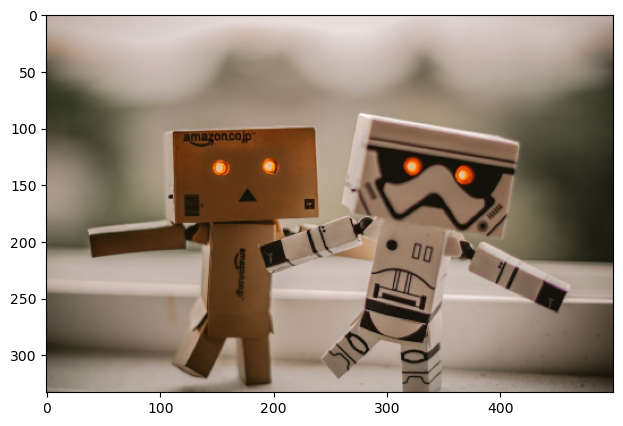

In [ ]:
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_width = 500  # arbitrary
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=img_width)

fig = plt.figure(figsize=(7.5,5), dpi=100)  # otherwise plots are really small in Jupyter Notebook
plt.imshow(img)
plt.show()

In [ ]:
# mean/std normalization - ImageNet's mean and std capture the statistics of natural images pretty nicely.
# This works for Places365 dataset as well (keep in mind you might have to change it if your dataset is way different)
def pre_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    img = (img - IMAGENET_MEAN_1) / IMAGENET_STD_1  # normalize image
    return img


def post_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    if img.shape[0] == 3:  # if channel-first format move to channel-last (CHW -> HWC)
        img = np.moveaxis(img, 0, 2)

    mean = IMAGENET_MEAN_1.reshape(1, 1, -1)
    std = IMAGENET_STD_1.reshape(1, 1, -1)
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range

    return img


def pytorch_input_adapter(img):
    # shape = (1, 3, H, W)
    tensor = transforms.ToTensor()(img).to(DEVICE).unsqueeze(0)
    tensor.requires_grad = True  # we need to collect gradients for the input image
    return tensor


def pytorch_output_adapter(tensor):
    # Push to CPU, detach from the computational graph, convert from (1, 3, H, W) tensor into (H, W, 3) numpy image
    return np.moveaxis(tensor.to('cpu').detach().numpy()[0], 0, 2)


# Adds stochasticity to the algorithm and makes the results more diverse
def random_circular_spatial_shift(tensor, h_shift, w_shift, should_undo=False):
    if should_undo:
        h_shift = -h_shift
        w_shift = -w_shift
    with torch.no_grad():
        rolled = torch.roll(tensor, shifts=(h_shift, w_shift), dims=(2, 3))
        rolled.requires_grad = True
        return rolled

In [ ]:
# again treat config as an oracle
def get_new_shape(config, original_shape, current_pyramid_level):
    SHAPE_MARGIN = 10
    pyramid_ratio = config['pyramid_ratio']
    pyramid_size = config['pyramid_size']
    exponent = current_pyramid_level - pyramid_size + 1  # this one will be negative so we're dividing the original img shape
    new_shape = np.round(np.float32(original_shape) * (pyramid_ratio**exponent)).astype(np.int32)

    if new_shape[0] < SHAPE_MARGIN or new_shape[1] < SHAPE_MARGIN:
        print(f'Pyramid size {config["pyramid_size"]} with pyramid ratio {config["pyramid_ratio"]} gives too small pyramid levels with size={new_shape}')
        print(f'Please change the parameters.')
        exit(0)

    return new_shape

In [ ]:
def deep_dream_static_image(config, img=None):
    model = fetch_and_prepare_model(config['model_name'], config['pretrained_weights'])

    try:
        layer_ids_to_use = [model.layer_names.index(layer_name) for layer_name in config['layers_to_use']]
    except Exception as e:  # making sure you set the correct layer name for this specific model
        print(f'Invalid layer names {[layer_name for layer_name in config["layers_to_use"]]}.')
        print(f'Available layers for model {config["model_name"]} are {model.layer_names}.')
        return

    if img is None:  # load either the provided image or start from a pure noise image
        img_path = os.path.join(INPUT_DATA_PATH, config['input'])
        # load a numpy, [0, 1] range, channel-last, RGB image
        img = load_image(img_path, target_shape=config['img_width'])
        if config['use_noise']:
            shape = img.shape
            img = np.random.uniform(low=0.0, high=1.0, size=shape).astype(np.float32)

    img = pre_process_numpy_img(img)
    original_shape = img.shape[:-1]  # save initial height and width

    # Note: simply rescaling the whole result (and not only details, see original implementation) gave me better results
    # Going from smaller to bigger resolution (from pyramid top to bottom)
    for pyramid_level in range(config['pyramid_size']):
        new_shape = get_new_shape(config, original_shape, pyramid_level)
        img = cv.resize(img, (new_shape[1], new_shape[0]))  # resize depending on the current pyramid level
        input_tensor = pytorch_input_adapter(img)  # convert to trainable tensor

        for iteration in range(config['num_gradient_ascent_iterations']):
            
            # Introduce some randomness, it will give us more diverse results especially when you're making videos
            h_shift, w_shift = np.random.randint(-config['spatial_shift_size'], config['spatial_shift_size'] + 1, 2)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift)

            # This is where the magic happens, treat it as a black box until the next cell
            gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration)

            # Roll back by the same amount as above (hence should_undo=True)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift, should_undo=True)

        img = pytorch_output_adapter(input_tensor)

    return post_process_numpy_img(img)

In [ ]:
LOWER_IMAGE_BOUND = torch.tensor((-IMAGENET_MEAN_1 / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)
UPPER_IMAGE_BOUND = torch.tensor(((1 - IMAGENET_MEAN_1) / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)


def gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration):
    # Step 0: Feed forward pass
    out = model(input_tensor)

    # Step 1: Grab activations/feature maps of interest
    activations = [out[layer_id_to_use] for layer_id_to_use in layer_ids_to_use]

    # Step 2: Calculate loss over activations
    losses = []
    for layer_activation in activations:
        # Use torch.norm(torch.flatten(layer_activation), p) with p=2 for L2 loss and p=1 for L1 loss. 
        # But I'll use the MSE as it works really good, I didn't notice any serious change when going to L1/L2.
        # using torch.zeros_like as if we wanted to make activations as small as possible but we'll do gradient ascent
        # and that will cause it to actually amplify whatever the network "sees" thus yielding the famous DeepDream look
        loss_component = torch.nn.MSELoss(reduction='mean')(layer_activation, torch.zeros_like(layer_activation))
        losses.append(loss_component)

    loss = torch.mean(torch.stack(losses))
    loss.backward()

    # Step 3: Process image gradients (smoothing + normalization, more an art then a science)
    grad = input_tensor.grad.data

    # Applies 3 Gaussian kernels and thus "blurs" or smoothens the gradients and gives visually more pleasing results
    # We'll see the details of this one in the next cell and that's all, you now understand DeepDream!
    sigma = ((iteration + 1) / config['num_gradient_ascent_iterations']) * 2.0 + config['smoothing_coefficient']
    smooth_grad = CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad)  # "magic number" 9 just works well

    # Normalize the gradients (make them have mean = 0 and std = 1)
    # I didn't notice any big difference normalizing the mean as well - feel free to experiment
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std

    # Step 4: Update image using the calculated gradients (gradient ascent step)
    input_tensor.data += config['lr'] * smooth_grad

    # Step 5: Clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    input_tensor.grad.data.zero_()
    input_tensor.data = torch.max(torch.min(input_tensor, UPPER_IMAGE_BOUND), LOWER_IMAGE_BOUND)

In [ ]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(DEVICE)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

In [ ]:
# Only a small subset is exposed by design to avoid cluttering
parser = argparse.ArgumentParser()

# Common params
parser.add_argument("--input", type=str, help="Input IMAGE or VIDEO name that will be used for dreaming", default='figures.jpg')
parser.add_argument("--img_width", type=int, help="Resize input image to this width", default=600)
parser.add_argument("--layers_to_use", type=str, nargs='+', help="Layer whose activations we should maximize while dreaming", default=['relu4_3'])
parser.add_argument("--model_name", choices=[m.name for m in SupportedModels],
                    help="Neural network (model) to use for dreaming", default=SupportedModels.VGG16_EXPERIMENTAL.name)
parser.add_argument("--pretrained_weights", choices=[pw.name for pw in SupportedPretrainedWeights],
                    help="Pretrained weights to use for the above model", default=SupportedPretrainedWeights.IMAGENET.name)

# Main params for experimentation (especially pyramid_size and pyramid_ratio)
parser.add_argument("--pyramid_size", type=int, help="Number of images in an image pyramid", default=4)
parser.add_argument("--pyramid_ratio", type=float, help="Ratio of image sizes in the pyramid", default=1.8)
parser.add_argument("--num_gradient_ascent_iterations", type=int, help="Number of gradient ascent iterations", default=10)
parser.add_argument("--lr", type=float, help="Learning rate i.e. step size in gradient ascent", default=0.09)

# You usually won't need to change these as often
parser.add_argument("--should_display", type=bool, help="Display intermediate dreaming results", default=False)
parser.add_argument("--spatial_shift_size", type=int, help='Number of pixels to randomly shift image before grad ascent', default=32)
parser.add_argument("--smoothing_coefficient", type=float, help='Directly controls standard deviation for gradient smoothing', default=0.5)
parser.add_argument("--use_noise", type=bool, help="Use noise as a starting point instead of input image", default=False)
args = parser.parse_args('')  # important to put '' in Jupyter otherwise it will complain

# Wrapping configuration into a dictionary
config = dict()
for arg in vars(args):
    config[arg] = getattr(args, arg)
config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
config['input'] = os.path.basename(config['input'])  # handle absolute and relative paths

E:\download\conda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


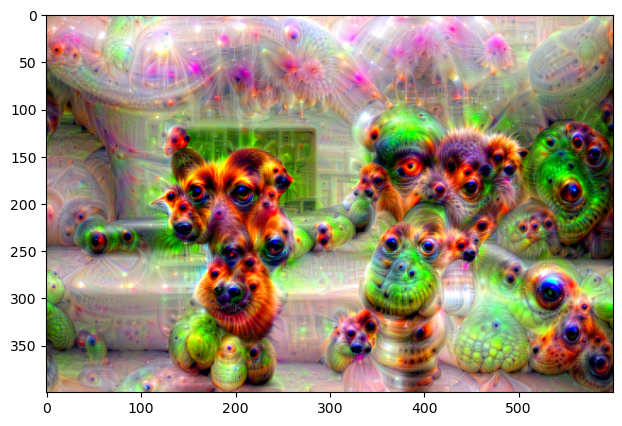

Saved DeepDream static image to: data\out-images\VGG16_EXPERIMENTAL_IMAGENET\figures_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_smooth_0.5.jpg



In [ ]:
img = deep_dream_static_image(config)  # yep a single liner


config['should_display'] = True
dump_path = save_and_maybe_display_image(config, img)
print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')